## Stock prices predict


- This project aims to predict stock prices for four companies from different sectors: UBER (transportation), INTEL (semiconductors), NETFLIX (entertainment), and NVIDIA (technology). To achieve this, various machine learning models are applied and compared, including Long Short-Term Memory (LSTM) networks, Feedforward Neural Networks (FFNN), Linear Regression, Support Vector Machines (SVM), Decision Trees, and Random Forests. Additionally, the models incorporate macroeconomic indicators as features—such as interest rates, inflation, and GDP growth—to enhance prediction accuracy and capture broader market influences. The goal is to evaluate and compare the performance of these models across different stock types and economic conditions.

### import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.regularizers import l2
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer


### Data process

In [ ]:
# Thiết lập phong cách cho biểu đồ
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

# Đường dẫn đến file dữ liệu
input_file = "market_stocks_new.csv"

# Đọc dữ liệu từ file CSV
try:
    df = pd.read_csv(input_file, index_col=0, parse_dates=True)
    print(f"Dữ liệu đã được đọc từ file: {input_file}")
except FileNotFoundError:
    print(f"File {input_file} không tồn tại. Vui lòng kiểm tra lại đường dẫn.")
    exit()

# Hiển thị 10 dòng cuối của dữ liệu
print(df.tail(10))

Dữ liệu đã được đọc từ file: market_stocks_new.csv
            Adj Close      Close       High        Low       Open   Volume  \
Date                                                                         
2023-12-15  48.876141  48.889999  49.403999  48.119999  48.194000  2376807   
2023-12-18  50.062805  50.077000  50.432999  49.150002  49.400002  2376807   
2023-12-19  49.589939  49.604000  49.700001  48.895000  49.424000  2376807   
2023-12-20  48.097359  48.111000  49.999001  48.098000  49.654999  2376807   
2023-12-21  48.976116  48.990002  49.095001  48.418999  48.811001  2376807   
2023-12-22  48.816162  48.830002  49.382999  48.466999  49.195000  2376807   
2023-12-26  49.265030  49.278999  49.599998  48.959999  48.967999  2376807   
2023-12-27  49.402992  49.417000  49.680000  49.084999  49.511002  2376807   
2023-12-28  49.507965  49.521999  49.883999  49.411999  49.643002  2376807   
2023-12-29  49.507965  49.521999  49.997002  48.750999  49.813000  2376807   

            

In [ ]:
df.describe()

,Adj Close,Close,High,Low,Open,Volume,GDP,CPI
count,3012.000000,3012.000000,3012.000000,3012.000000,3012.000000,3.012000e+03,3.012000e+03,3.012000e+03
mean,129.067002,129.708046,131.691082,127.725622,129.733528,7.956747e+06,5.140123e+05,1.255493e+08
std,176.378299,176.082653,178.474375,173.778797,176.208436,1.393318e+07,8.930030e+05,2.116942e+08
min,11.215970,11.227000,11.735000,10.813000,10.971000,1.825070e+05,2.625180e+02,2.625180e+02
25%,28.028666,28.477499,28.950001,27.967500,28.397500,2.275118e+06,2.808080e+02,9.654772e+05
50%,43.417858,43.825001,44.549999,43.247999,43.915001,2.312426e+06,2.988120e+02,1.767620e+07
75%,89.052498,92.787500,94.382498,90.650000,92.139999,3.082705e+06,4.480198e+05,1.463178e+08
max,691.690002,691.690002,700.989990,686.090027,692.349976,3.642318e+08,2.267529e+06,1.543911e+09


In [ ]:
# Kiểm tra và xử lý cột industry_type
if 'industry_type' not in df.columns:
    print("Dữ liệu không chứa cột 'industry_type'. Vui lòng kiểm tra lại.")
else:
    print("Unique values in 'industry_type' before encoding:", df['industry_type'].unique())
    label_encoder = LabelEncoder()
    df['industry_type'] = label_encoder.fit_transform(df['industry_type'])

Unique values in 'industry_type' before encoding: ['TECH' 'MANUFACTURE' 'ENTERTAINTMENT']


In [ ]:
# Chuẩn hóa dữ liệu industry_type
scaler = MinMaxScaler()
df['industry_type_scaled'] = scaler.fit_transform(df[['industry_type']])
print("Unique values in 'industry_type' after encoding:", df['industry_type'].unique())
print("Unique values in 'industry_type_scaled' after encoding:", df['industry_type_scaled'].unique())

Unique values in 'industry_type' after encoding: [2 1 0]
Unique values in 'industry_type_scaled' after encoding: [1.  0.5 0. ]


In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3012 entries, 2021-01-04 to 2023-12-29
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Adj Close             3012 non-null   float64
 1   Close                 3012 non-null   float64
 2   High                  3012 non-null   float64
 3   Low                   3012 non-null   float64
 4   Open                  3012 non-null   float64
 5   Volume                3012 non-null   int64  
 6   GDP                   3012 non-null   float64
 7   CPI                   3012 non-null   float64
 8   industry_type         3012 non-null   int64  
 9   Company               3012 non-null   object 
 10  industry_type_scaled  3012 non-null   float64
dtypes: float64(8), int64(2), object(1)
memory usage: 282.4+ KB


,Adj Close,Close,High,Low,Open,Volume,GDP,CPI,industry_type,industry_type_scaled
count,3012.000000,3012.000000,3012.000000,3012.000000,3012.000000,3.012000e+03,3.012000e+03,3.012000e+03,3012.000000,3012.000000
mean,129.067002,129.708046,131.691082,127.725622,129.733528,7.956747e+06,5.140123e+05,1.255493e+08,1.000000,0.500000
std,176.378299,176.082653,178.474375,173.778797,176.208436,1.393318e+07,8.930030e+05,2.116942e+08,0.707224,0.353612
min,11.215970,11.227000,11.735000,10.813000,10.971000,1.825070e+05,2.625180e+02,2.625180e+02,0.000000,0.000000
25%,28.028666,28.477499,28.950001,27.967500,28.397500,2.275118e+06,2.808080e+02,9.654772e+05,0.750000,0.375000
50%,43.417858,43.825001,44.549999,43.247999,43.915001,2.312426e+06,2.988120e+02,1.767620e+07,1.000000,0.500000
75%,89.052498,92.787500,94.382498,90.650000,92.139999,3.082705e+06,4.480198e+05,1.463178e+08,1.250000,0.625000
max,691.690002,691.690002,700.989990,686.090027,692.349976,3.642318e+08,2.267529e+06,1.543911e+09,2.000000,1.000000


In [ ]:
# Tạo DataFrame riêng cho từng công ty với xử lý NaN
company_dataframes = {}
for company in df['Company'].unique():
    temp_df = df[df['Company'] == company].copy()

    # Xử lý NaN cho từng DataFrame công ty
    numeric_columns = temp_df.select_dtypes(include=['number']).columns
    non_numeric_columns = temp_df.select_dtypes(exclude=['number']).columns

    imputer = SimpleImputer(strategy='mean')
    temp_df[numeric_columns] = imputer.fit_transform(temp_df[numeric_columns])
    temp_df[non_numeric_columns] = temp_df[non_numeric_columns].fillna('Unknown')

    # Lọc cột liên quan
    temp_df = temp_df[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'industry_type', 'industry_type_scaled','GDP','CPI']]
    company_dataframes[company] = temp_df


# Hiển thị thông tin cơ bản của mỗi công ty
for company, company_df in company_dataframes.items():
    print(f"{company}: {company_df.shape[0]} rows")
    print(f"Sample data from {company}:")
    print(company_df.head())

UBER: 753 rows
Sample data from UBER:
            Adj Close      Close       High        Low       Open      Volume  \
Date                                                                            
2021-01-04  51.139999  51.139999  52.320000  49.634998  52.220001  17291800.0   
2021-01-05  54.009998  54.009998  54.189999  50.759998  51.000000  21403200.0   
2021-01-06  52.480000  52.480000  54.070000  52.000000  53.310001  17738100.0   
2021-01-07  56.130001  56.130001  56.250000  53.200001  53.369999  23737500.0   
2021-01-08  53.279999  53.279999  54.790001  52.580002  54.395000  37999400.0   

            industry_type  industry_type_scaled        GDP      CPI  
Date                                                                 
2021-01-04            2.0                   1.0  1791153.0  262.518  
2021-01-05            2.0                   1.0  1791153.0  262.518  
2021-01-06            2.0                   1.0  1791153.0  262.518  
2021-01-07            2.0                   

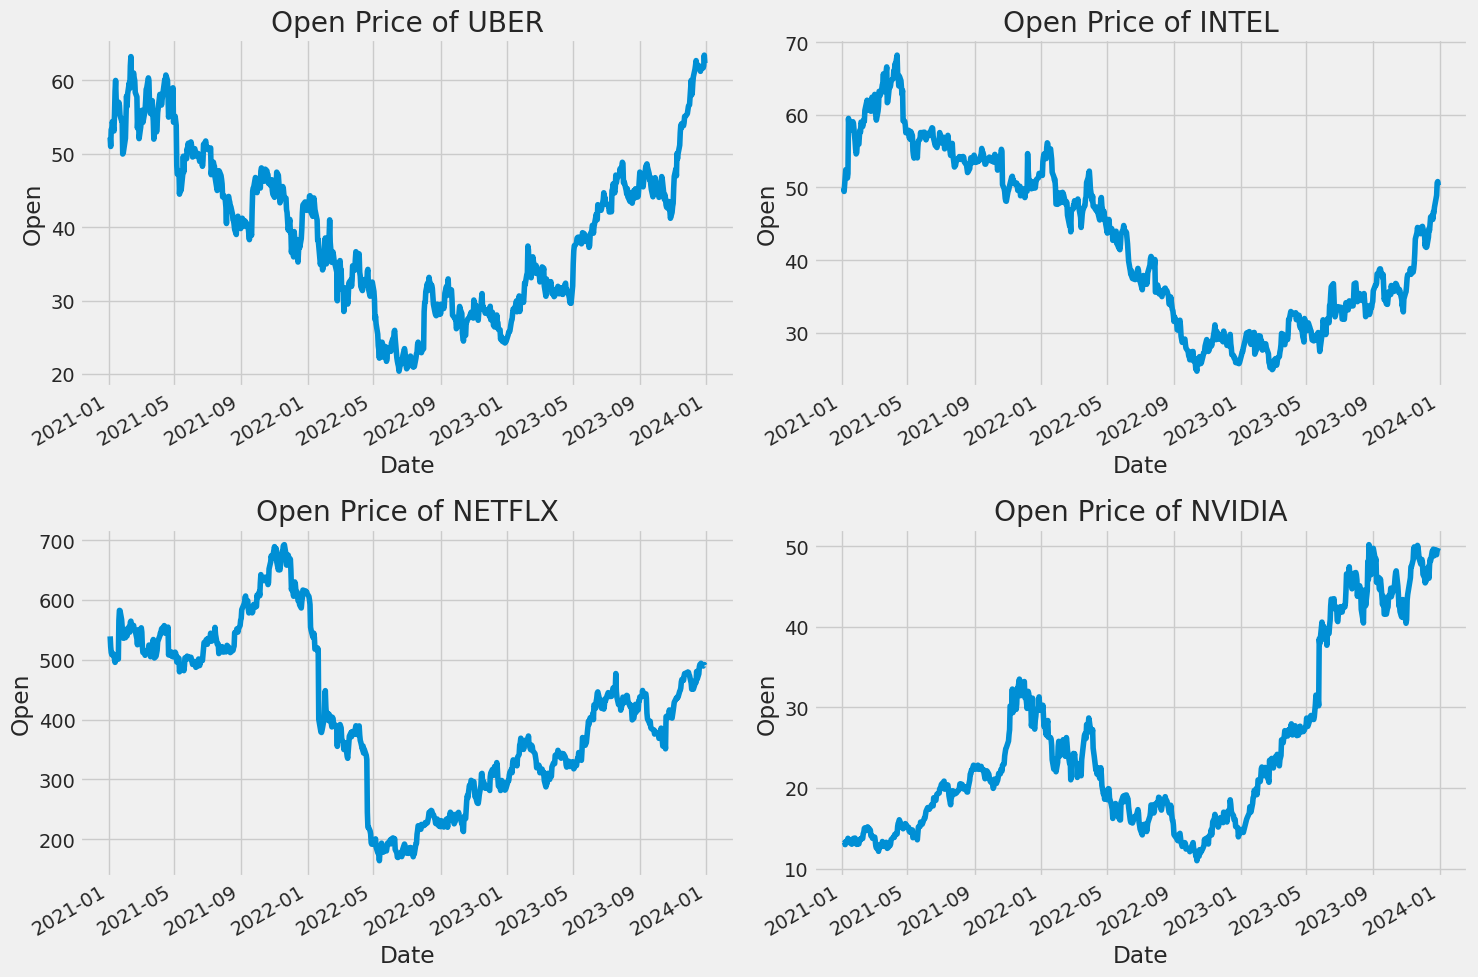

In [ ]:
# Vẽ biểu đồ giá mở cửa của từng công ty
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, (company, df) in enumerate(company_dataframes.items(), 1):
    plt.subplot(2, 2, i)
    df['Open'].plot()
    plt.ylabel('Open')
    plt.title(f"Open Price of {company}")

plt.tight_layout()
plt.show()

In [ ]:
# Tính toán Moving Averages
ma_days = [10, 20, 50]
for company, df in company_dataframes.items():
    for ma in ma_days:
        column_name = f"MA for {ma} days"
        df[column_name] = df['Open'].rolling(ma).mean()

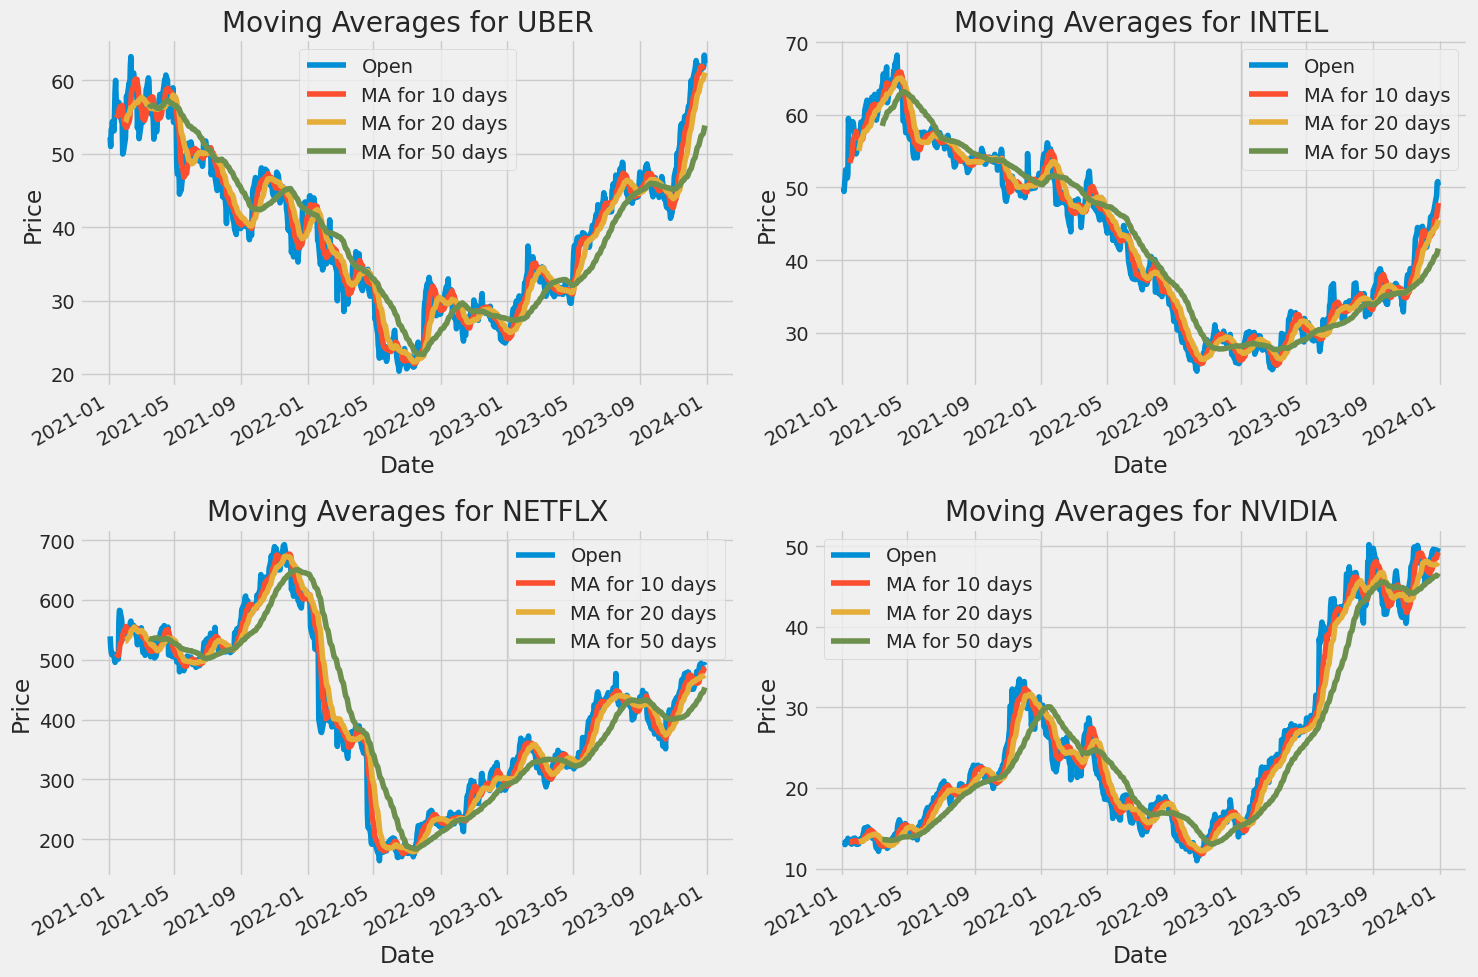

In [ ]:
# Vẽ biểu đồ Moving Averages
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for ax, (company, df) in zip(axes.flatten(), company_dataframes.items()):
    df[['Open', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=ax)
    ax.set_title(f"Moving Averages for {company}")
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

plt.tight_layout()
plt.show()

In [ ]:
company_df.describe()

,Adj Close,Close,High,Low,Open,Volume,industry_type,industry_type_scaled,GDP,CPI,MA for 10 days,MA for 20 days,MA for 50 days
count,753.000000,753.000000,753.000000,753.000000,753.000000,7.530000e+02,753.0,753.0,753.000000,7.530000e+02,744.000000,734.000000,704.000000
mean,24.837371,24.864097,25.315043,24.368803,24.847652,2.306339e+06,1.0,0.5,289.467169,4.586084e+08,24.769240,24.687260,24.436341
std,11.196268,11.194415,11.349365,11.040056,11.215652,3.852860e+04,0.0,0.0,14.713232,1.739327e+08,11.030409,10.836225,10.239658
min,11.215970,11.227000,11.735000,10.813000,10.971000,2.247775e+06,1.0,0.5,262.518000,1.462760e+08,11.815700,12.198100,13.011140
25%,15.975381,15.987000,16.309999,15.597000,16.000000,2.275980e+06,1.0,0.5,276.434000,3.449790e+08,16.015200,16.058231,16.579820
50%,21.249542,21.264999,21.799000,20.888000,21.214001,2.302390e+06,1.0,0.5,294.996000,4.467990e+08,21.343800,21.325650,21.301020
75%,29.406487,29.459000,30.389999,28.778000,29.674000,2.345034e+06,1.0,0.5,301.744000,5.514090e+08,29.306875,29.065975,28.492215
max,50.390285,50.409000,50.548000,49.411999,50.216000,2.376807e+06,1.0,0.5,308.742000,1.543911e+09,49.261400,48.134350,46.666260


In [ ]:
# Chọn dữ liệu cho một công ty để huấn luyện
company_name = 'NVIDIA'  # Có thể thay đổi tên công ty theo nhu cầu
if company_name in company_dataframes:
    company_df = company_dataframes[company_name]
else:
    raise ValueError(f"Công ty {company_name} không tồn tại trong dữ liệu.")

features = company_df.drop(['Open'], axis=1).values
target = company_df['Open'].values

In [ ]:
# Kiểm tra NaN hoặc Inf trong dữ liệu trước khi chuẩn hóa
print("Kiểm tra NaN:", np.isnan(features).any())
print("Kiểm tra Inf:", np.isinf(features).any())

# Kiểm tra thống kê cơ bản để xác định các cột bất thường
print(pd.DataFrame(features).describe())


Kiểm tra NaN: True
Kiểm tra Inf: False
               0           1           2           3             4      5   \
count  753.000000  753.000000  753.000000  753.000000  7.530000e+02  753.0   
mean    24.837371   24.864097   25.315043   24.368803  2.306339e+06    1.0   
std     11.196268   11.194415   11.349365   11.040056  3.852860e+04    0.0   
min     11.215970   11.227000   11.735000   10.813000  2.247775e+06    1.0   
25%     15.975381   15.987000   16.309999   15.597000  2.275980e+06    1.0   
50%     21.249542   21.264999   21.799000   20.888000  2.302390e+06    1.0   
75%     29.406487   29.459000   30.389999   28.778000  2.345034e+06    1.0   
max     50.390285   50.409000   50.548000   49.411999  2.376807e+06    1.0   

          6           7             8           9           10          11  
count  753.0  753.000000  7.530000e+02  744.000000  734.000000  704.000000  
mean     0.5  289.467169  4.586084e+08   24.769240   24.687260   24.436341  
std      0.0   14.713232  1

In [ ]:
# Chuẩn hóa dữ liệu
scaled_features = scaler.fit_transform(features)
target_scaler = MinMaxScaler()
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))

In [ ]:
# Kiểm tra và xử lý NaN trong scaled_features
if np.isnan(scaled_features).any():
    print("NaN được phát hiện trong scaled_features. Xử lý bằng cách thay thế giá trị NaN.")
    nan_indices = np.where(np.isnan(scaled_features))
    print(f"Vị trí NaN: {nan_indices}")

    # Thay thế giá trị NaN bằng trung bình cột tương ứng
    col_means = np.nanmean(scaled_features, axis=0)
    for col in nan_indices[1]:  # Duyệt qua các cột chứa NaN
        scaled_features[:, col] = np.nan_to_num(scaled_features[:, col], nan=col_means[col])

print("Chuẩn hóa dữ liệu hoàn tất!")


NaN được phát hiện trong scaled_features. Xử lý bằng cách thay thế giá trị NaN.
Vị trí NaN: (array([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,
        5,  6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9, 10, 10, 11, 11, 12,
       12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48]), array([ 9, 10, 11,  9, 10, 11,  9, 10, 11,  9, 10, 11,  9, 10, 11,  9, 10,
       11,  9, 10, 11,  9, 10, 11,  9, 10, 11, 10, 11, 10, 11, 10, 11, 10,
       11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 10, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11]))
Chuẩn hóa dữ liệu hoàn tất!


In [ ]:
# Tạo dữ liệu huấn luyện
training_data_len = int(np.ceil(len(features) * 0.8))
train_features = scaled_features[:training_data_len, :]
train_target = scaled_target[:training_data_len, :]

x_train, y_train = [], []
for i in range(60, len(train_features)):
    x_train.append(train_features[i-60:i, :])
    y_train.append(train_target[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))


In [ ]:
x_train.shape, y_train.shape

((543, 60, 12), (543,))

In [ ]:
# Tạo dữ liệu kiểm tra
x_test, y_test = [], []
for i in range(60, len(scaled_features[training_data_len:, :]) + training_data_len):  # Giữ trong khoảng kiểm tra
    x_test.append(scaled_features[i-60:i, :])
    y_test.append(scaled_target[i, 0])


x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

In [ ]:
x_test.shape

(693, 60, 12)

### Long Short term memory (LTSM-RNN)

In [ ]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Dropout(0.2))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_rnn = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stop])


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 459ms/step - loss: 0.0506 - val_loss: 0.0105
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 298ms/step - loss: 0.0048 - val_loss: 0.0133
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 424ms/step - loss: 0.0031 - val_loss: 0.0168
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 300ms/step - loss: 0.0022 - val_loss: 0.0133
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 370ms/step - loss: 0.0019 - val_loss: 0.0139
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 430ms/step - loss: 0.0019 - val_loss: 0.0140
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 302ms/step - loss: 0.0017 - val_loss: 0.0115
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 294ms/step - loss: 0.0017 - val_loss: 0.0103
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 426ms/step - loss: 0.0017 - val_loss: 0.0122
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step - loss: 0.0015 - val_loss: 0.0160
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - loss: 0.0021 - val_loss: 0.0082
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 345ms/ste

In [ ]:
predictions = model.predict(x_test)
predictions = target_scaler.inverse_transform(predictions)

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step


In [ ]:
# Tính RMSE
actual = target[60:]
rmse_ltsm = np.sqrt(np.mean(((predictions.flatten() - actual) ** 2)))
print(f"RMSE: {rmse_ltsm}")

# Tính MAE (Mean Absolute Error)
mae_ltsm = mean_absolute_error(actual, predictions.flatten())
print(f"MAE: {mae_ltsm}")

# Tính R² Score
r2_ltsm = r2_score(actual, predictions.flatten())
print(f"R² Score: {r2_ltsm}")

RMSE: 3.3606591536612345
MAE: 2.1365188856020763
R² Score: 0.9091325235692255


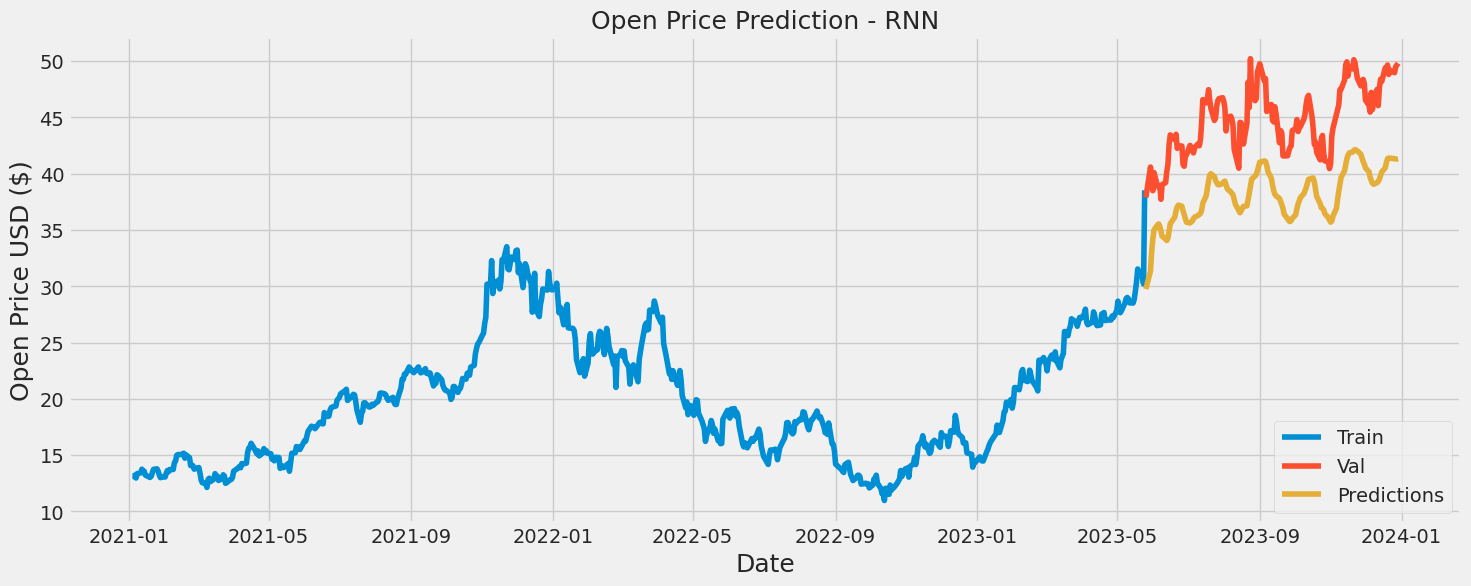

In [ ]:
# Biểu đồ dự đoán
train = company_df[:training_data_len]
valid = company_df[training_data_len:]
valid = valid.copy()
valid['Predictions'] = predictions[-len(valid):]

plt.figure(figsize=(16, 6))
plt.title('Open Price Prediction - RNN', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.plot(train['Open'], label='Train')
plt.plot(valid['Open'], label='Val')
plt.plot(valid['Predictions'], label='Predictions')
plt.legend(loc='lower right')
plt.show()


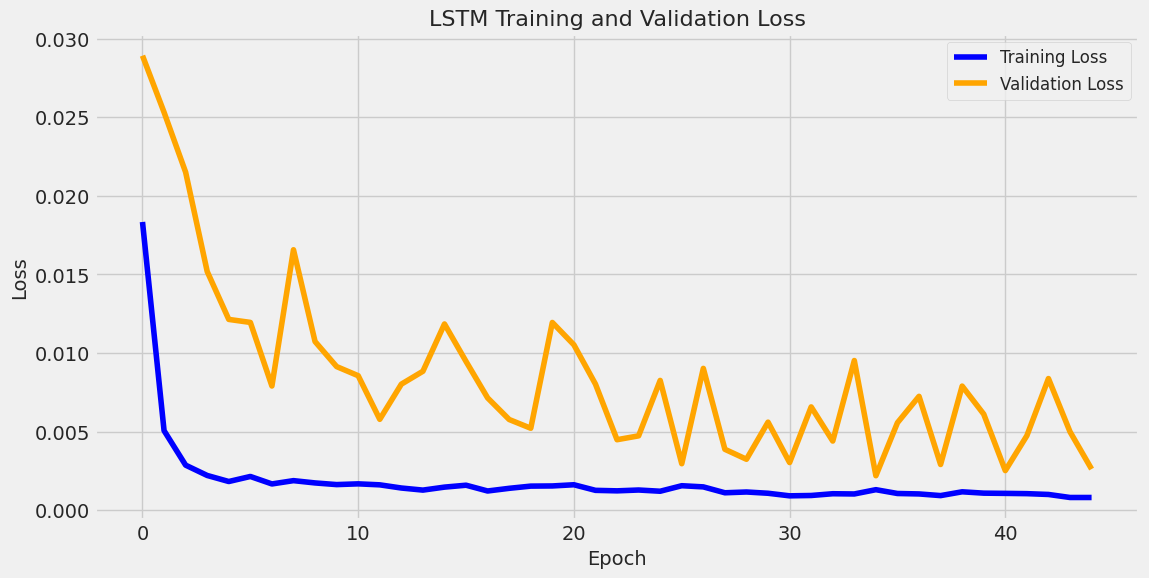

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history_rnn.history['loss'], label='Training Loss', color='blue')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss', color='orange')
plt.title('LSTM Training and Validation Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

Processing predictions for UBER...
Handling NaN for UBER data.
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step
UBER RMSE: 3.067899219371845
UBER MAE: 2.3321310980501586
UBER R² Score: 0.9062086360091066


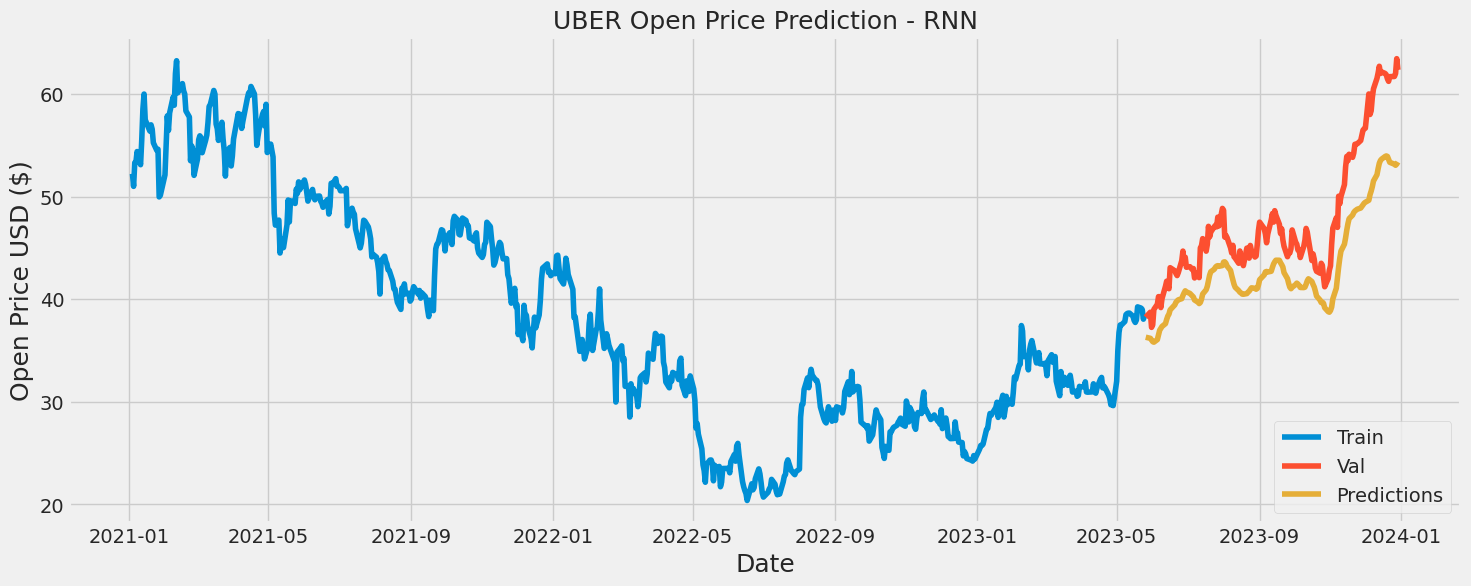

Processing predictions for INTEL...
Handling NaN for INTEL data.
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step
INTEL RMSE: 1.9409120557547703
INTEL MAE: 1.481602527090471
INTEL R² Score: 0.9678898436225608


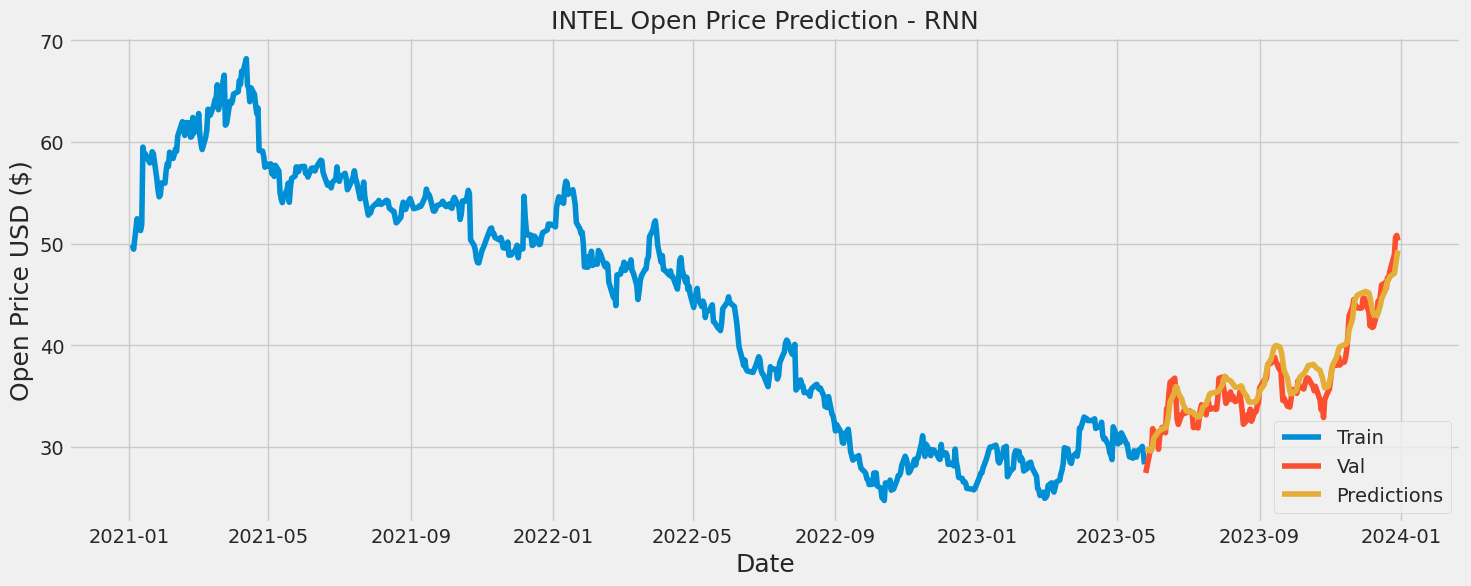

Processing predictions for NETFLX...
Handling NaN for NETFLX data.
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step
NETFLX RMSE: 37.15229587341639
NETFLX MAE: 27.571166838794188
NETFLX R² Score: 0.9231621220186089


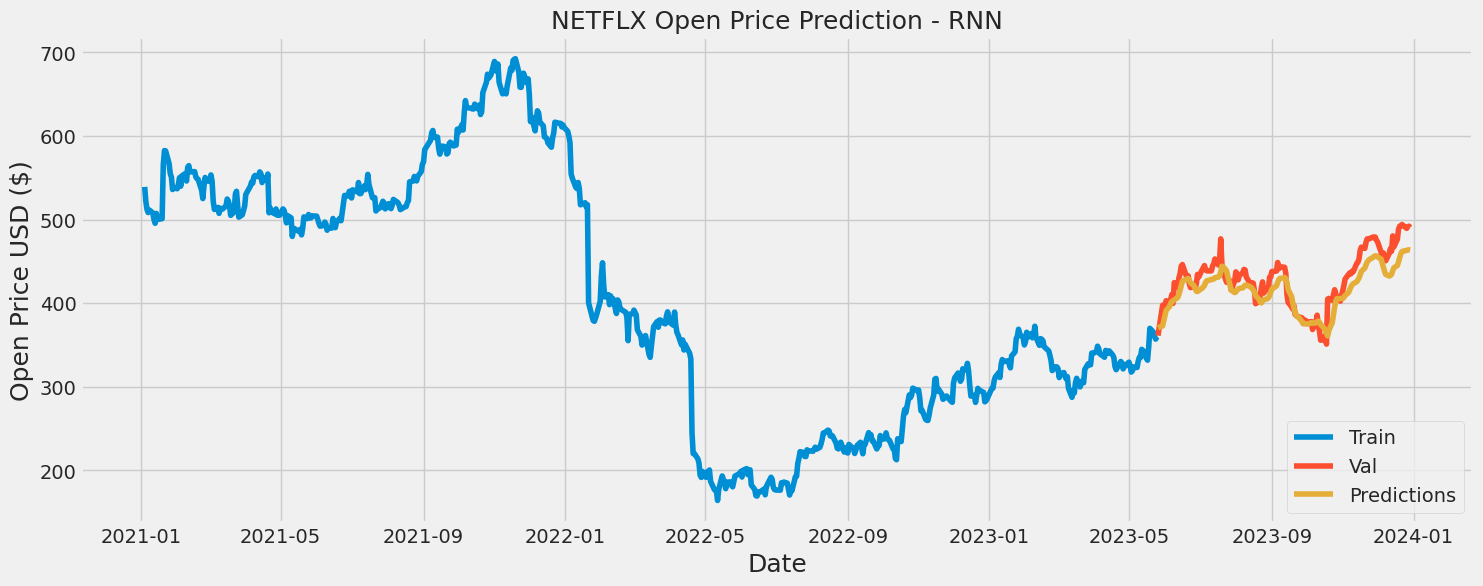

Processing predictions for NVIDIA...
Handling NaN for NVIDIA data.
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step
NVIDIA RMSE: 3.0089171185802552
NVIDIA MAE: 2.000911472953253
NVIDIA R² Score: 0.9271583151954172


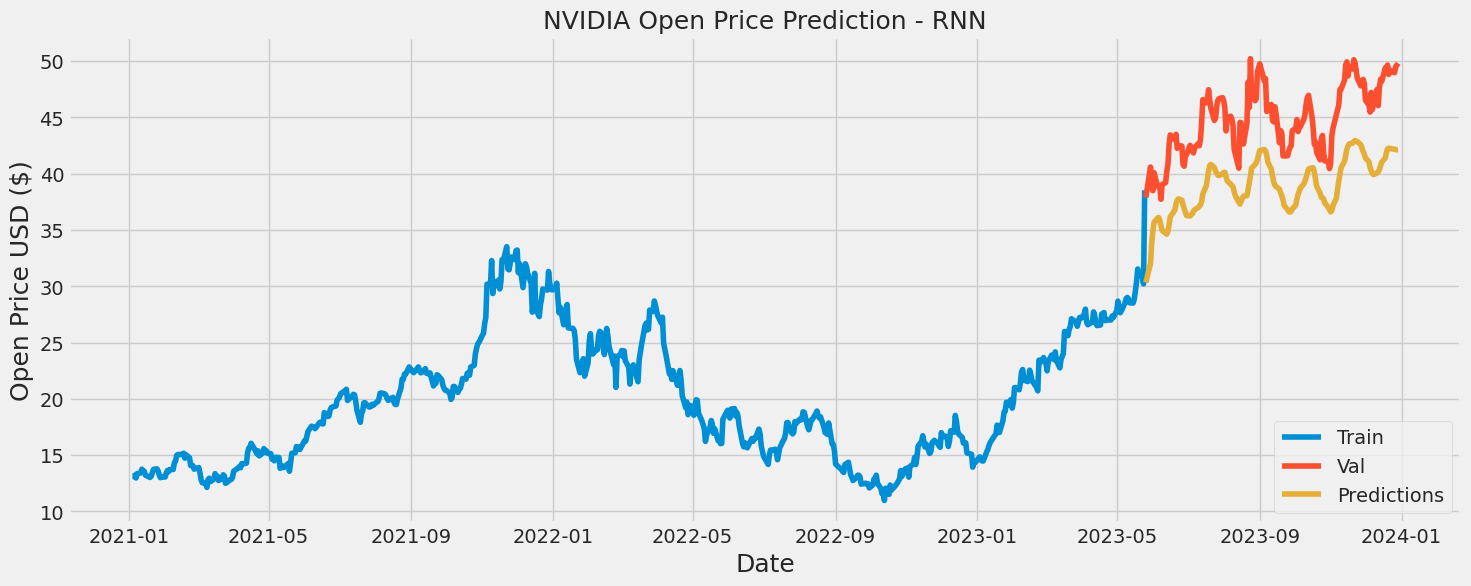

In [ ]:
# Tạo biểu đồ dự đoán cho từng công ty
for company, company_df in company_dataframes.items():
    print(f"Processing predictions for {company}...")

    # Chọn dữ liệu của công ty
    features = company_df.drop(['Open'], axis=1).values
    target = company_df['Open'].values

    # Xử lý NaN trước khi chuẩn hóa
    if np.isnan(features).any() or np.isnan(target).any():
        print(f"Handling NaN for {company} data.")
        col_means = np.nanmean(features, axis=0)
        nan_indices = np.where(np.isnan(features))
        for col in nan_indices[1]:
            features[:, col] = np.nan_to_num(features[:, col], nan=col_means[col])
        target = np.nan_to_num(target, nan=np.nanmean(target))

    # Chuẩn hóa dữ liệu
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)
    target_scaler = MinMaxScaler()
    scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))

    # Tạo dữ liệu huấn luyện
    training_data_len = int(np.ceil(len(features) * 0.8))
    train_features = scaled_features[:training_data_len, :]
    train_target = scaled_target[:training_data_len, :]

    x_train, y_train = [], []
    for i in range(60, len(train_features)):
        x_train.append(train_features[i-60:i, :])
        y_train.append(train_target[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

    # Dự đoán trên dữ liệu kiểm tra
    x_test, y_test = [], []
    for i in range(60, len(scaled_features)):
        x_test.append(scaled_features[i-60:i])
        y_test.append(scaled_target[i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

    # Thực hiện dự đoán
    predictions = model.predict(x_test)
    predictions = target_scaler.inverse_transform(predictions)

    # Tính RMSE
    actual = target[60:]
    rmse = np.sqrt(np.mean(((predictions.flatten() - actual) ** 2)))
    print(f"{company} RMSE: {rmse}")

    # Tính MAE (Mean Absolute Error)
    mae = mean_absolute_error(actual, predictions.flatten())
    print(f"{company} MAE: {mae}")

    # Tính R² Score
    r2 = r2_score(actual, predictions.flatten())
    print(f"{company} R² Score: {r2}")

    # Biểu đồ
    train = company_df[:training_data_len]
    valid = company_df[training_data_len:]
    valid = valid.copy()
    valid['Predictions'] = predictions[-len(valid):]

    plt.figure(figsize=(16, 6))
    plt.title(f'{company} Open Price Prediction - RNN', fontsize=18)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Open Price USD ($)', fontsize=18)
    plt.plot(train['Open'], label='Train')
    plt.plot(valid['Open'], label='Val')
    plt.plot(valid['Predictions'], label='Predictions')
    plt.legend(loc='lower right')
    plt.show()


### FFNN

In [ ]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test_scaled = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)


In [ ]:
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

In [ ]:
# Giả sử dữ liệu có dạng (số mẫu, số bước thời gian, số đặc trưng)
print("Dữ liệu trước khi làm phẳng:", x_train.shape)  # Ví dụ: (1000, 10, 5)

# Làm phẳng dữ liệu
x_train_flattened = x_train_scaled.reshape(x_train_scaled.shape[0], -1)
x_test_flattened = x_test_scaled.reshape(x_test_scaled.shape[0], -1)

print("Dữ liệu sau khi làm phẳng:", x_train_flattened.shape)  # Ví dụ: (1000, 50)
print("Dữ liệu sau khi làm phẳng:", x_test_flattened.shape)  # Ví dụ: (1000, 50)


Dữ liệu trước khi làm phẳng: (543, 60, 10)
Dữ liệu sau khi làm phẳng: (543, 600)
Dữ liệu sau khi làm phẳng: (693, 600)


In [ ]:
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2

# Đặt seed để cố định ngẫu nhiên
seed = 57
tf.random.set_seed(seed)  # TensorFlow
np.random.seed(seed)      # NumPy
random.seed(seed)         # Python

# Hàm Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.9  # Không thay đổi lr
    return lr

# Xây dựng mô hình FFNN
ffnn_model = Sequential()

# Lớp ẩn 1
ffnn_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0005)))
ffnn_model.add(BatchNormalization())
ffnn_model.add(Dropout(0.2))  # Dropout vẫn hoạt động nhưng sẽ tái lập với seed

# Lớp ẩn 2
ffnn_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0005)))
ffnn_model.add(BatchNormalization())
ffnn_model.add(Dropout(0.2))

# Lớp ẩn 3
ffnn_model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.0005)))
ffnn_model.add(BatchNormalization())
ffnn_model.add(Dropout(0.2))

# Lớp đầu ra
ffnn_model.add(Dense(1))

# Biên dịch mô hình
optimizer = RMSprop(learning_rate=0.0005)
ffnn_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
lr_scheduler = LearningRateScheduler(scheduler)

# Huấn luyện mô hình
history_ffnn = ffnn_model.fit(
    x_train_flattened,
    y_train_scaled,
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    shuffle=True,  # Shuffle vẫn giữ để cải thiện tổng quát hóa
    callbacks=[early_stop, lr_scheduler]
)



Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.6822 - val_loss: 0.4535 - learning_rate: 5.0000e-04
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0116 - val_loss: 0.2855 - learning_rate: 5.0000e-04
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8786 - val_loss: 0.2901 - learning_rate: 5.0000e-04
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7908 - val_loss: 0.3265 - learning_rate: 5.0000e-04
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6377 - val_loss: 0.3286 - learning_rate: 5.0000e-04
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6273 - val_loss: 0.2588 - learning_rate: 5.0000e-04
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6161 - val_loss: 0.2936 - learning_rate: 5.0000e-04
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5585 - val_loss: 0.2507 - learning_rate: 5.0000e-04
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5655 - val_loss: 0.2076 - learning

In [ ]:
predictions_ffnn = ffnn_model.predict(x_test_flattened)
predictions_ffnn = target_scaler.inverse_transform(predictions_ffnn)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
# Tính RMSE
actual = target[60:]
rmse_ffnn = np.sqrt(np.mean(((predictions_ffnn.flatten() - actual) ** 2)))
print(f"RMSE: {rmse_ffnn}")

# Tính MAE (Mean Absolute Error)
mae_ffnn = mean_absolute_error(actual, predictions_ffnn.flatten())
print(f"MAE: {mae_ffnn}")

# Tính R² Score
r2_ffnn = r2_score(actual, predictions_ffnn.flatten())
print(f"R² Score: {r2_ffnn}")

RMSE: 3.6883191286308197
MAE: 2.7699343378428396
R² Score: 0.8905498114765761


x_test shape: (693, 600), Valid shape: (150, 11)


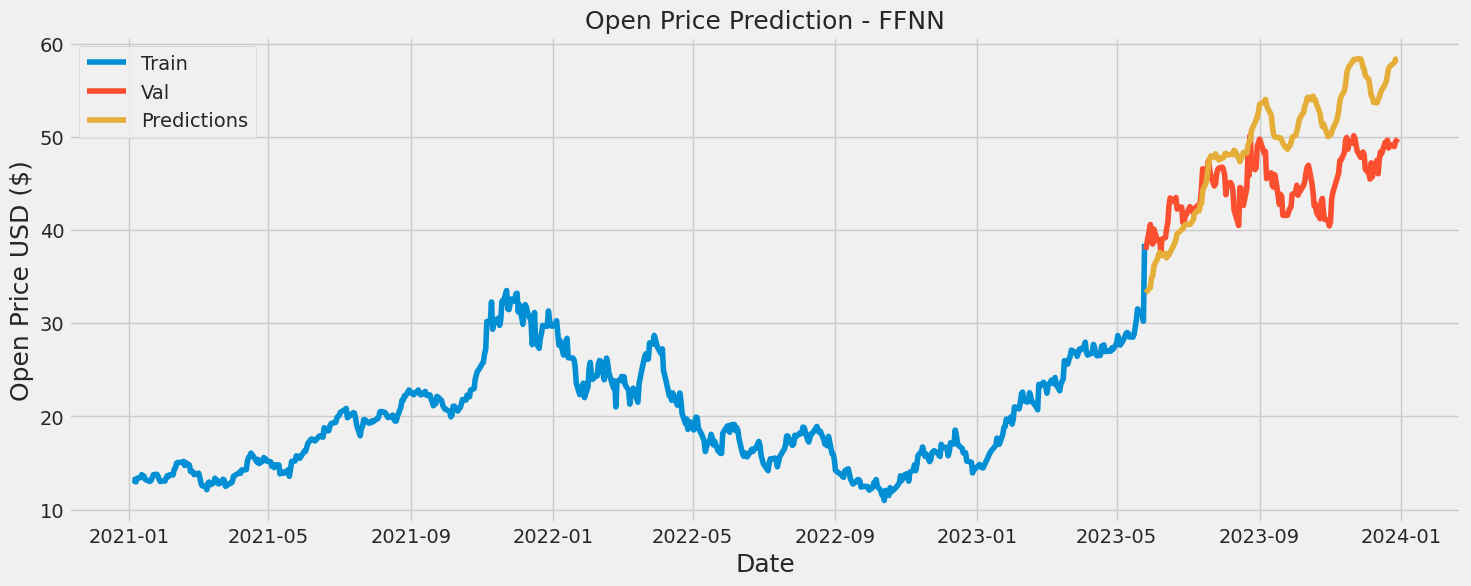

In [ ]:
# Giả sử rằng bạn đã chia dữ liệu đúng cách và X_test và y_test đã được định nghĩa:
valid = company_df[training_data_len:].copy()

# Kiểm tra lại dữ liệu X_test có cùng số lượng mẫu với valid
print(f"x_test shape: {x_test_flattened.shape}, Valid shape: {valid.shape}")

# Dự đoán với mô hình FFNN
valid['Predictions'] = predictions_ffnn[-len(valid):]  # Dự đoán cho tập kiểm tra

# Vẽ biểu đồ
plt.figure(figsize=(16, 6))
plt.title('Open Price Prediction - FFNN', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)

# Vẽ giá trị thực tế và dự đoán
plt.plot(train['Open'], label='Train')  # Dữ liệu huấn luyện
plt.plot(valid['Open'], label='Val')   # Dữ liệu kiểm tra thực tế
plt.plot(valid['Predictions'], label='Predictions')  # Dự đoán

plt.legend(loc='upper left')
plt.show()


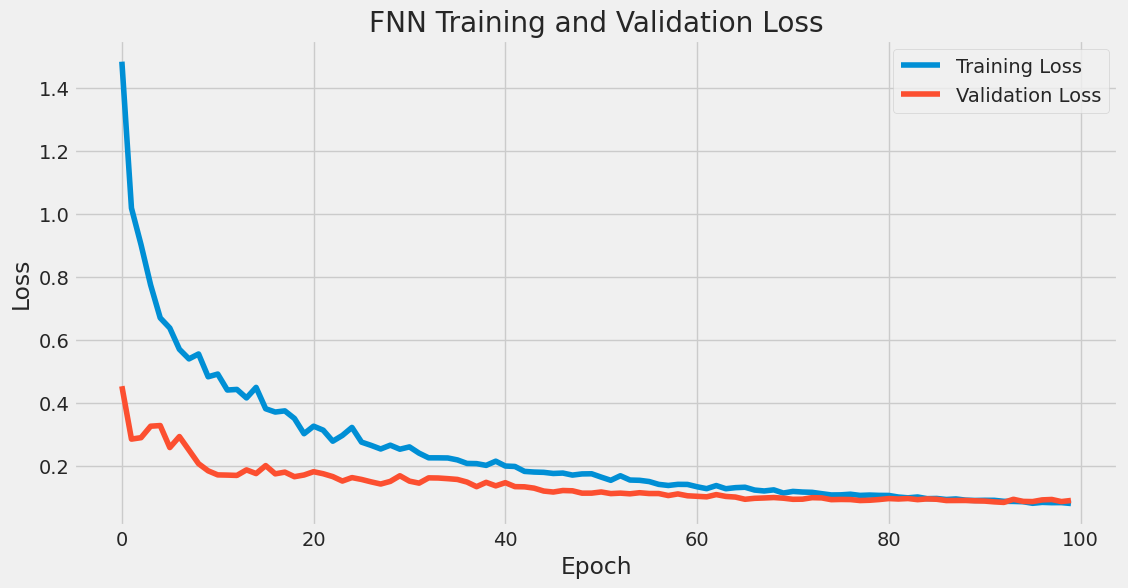

In [ ]:
# Biểu đồ mất mát của Feedforward Neural Network
plt.figure(figsize=(12, 6))
plt.plot(history_ffnn.history['loss'], label='Training Loss')
plt.plot(history_ffnn.history['val_loss'], label='Validation Loss')
plt.title('FNN Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Processing predictions for UBER...
Handling NaN for UBER data.
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
UBER RMSE: 7.104550167037399
UBER MAE: 5.76657081363029
UBER R² Score: 0.49701637736363047


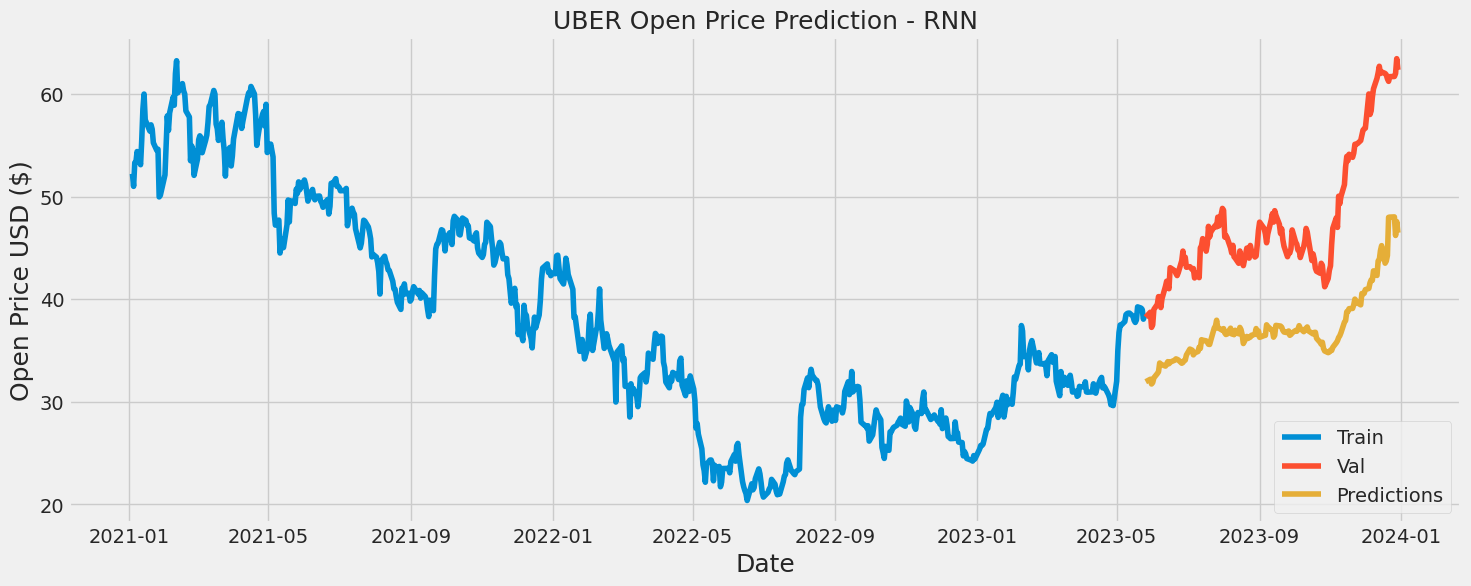

Processing predictions for INTEL...
Handling NaN for INTEL data.
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
INTEL RMSE: 5.850019427237881
INTEL MAE: 4.8075764616746355
INTEL R² Score: 0.7082940268922263


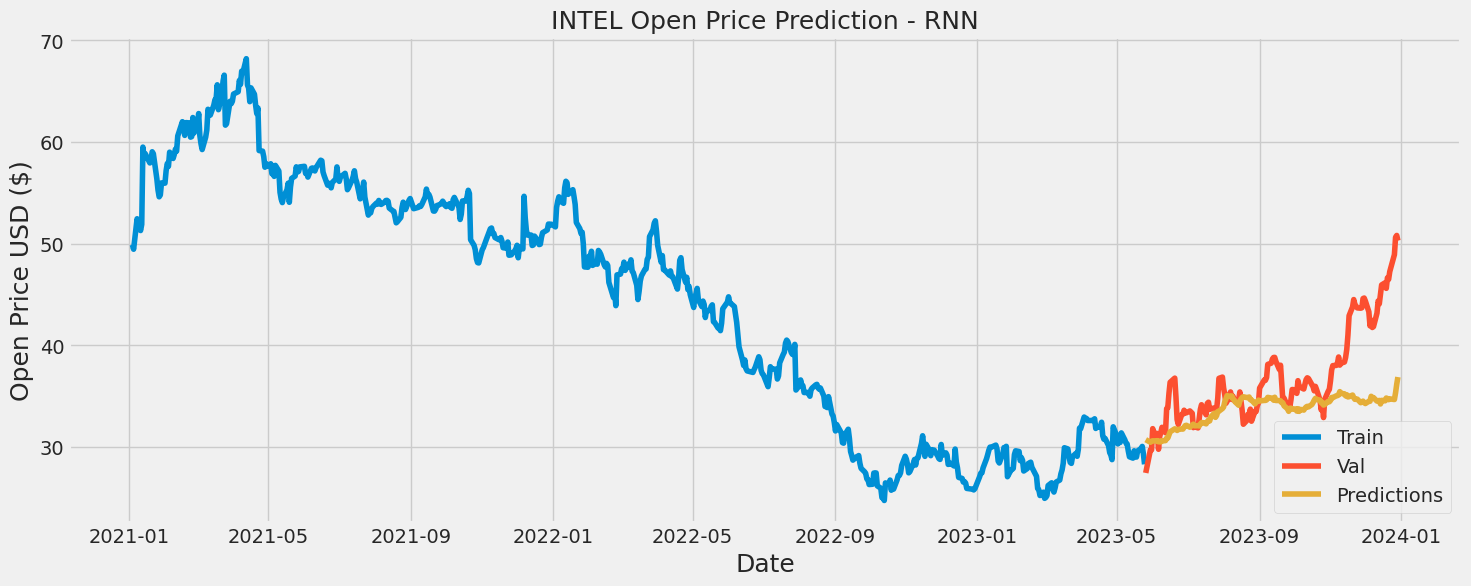

Processing predictions for NETFLX...
Handling NaN for NETFLX data.
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
NETFLX RMSE: 93.85348608586007
NETFLX MAE: 79.86225358384345
NETFLX R² Score: 0.5096514827206652


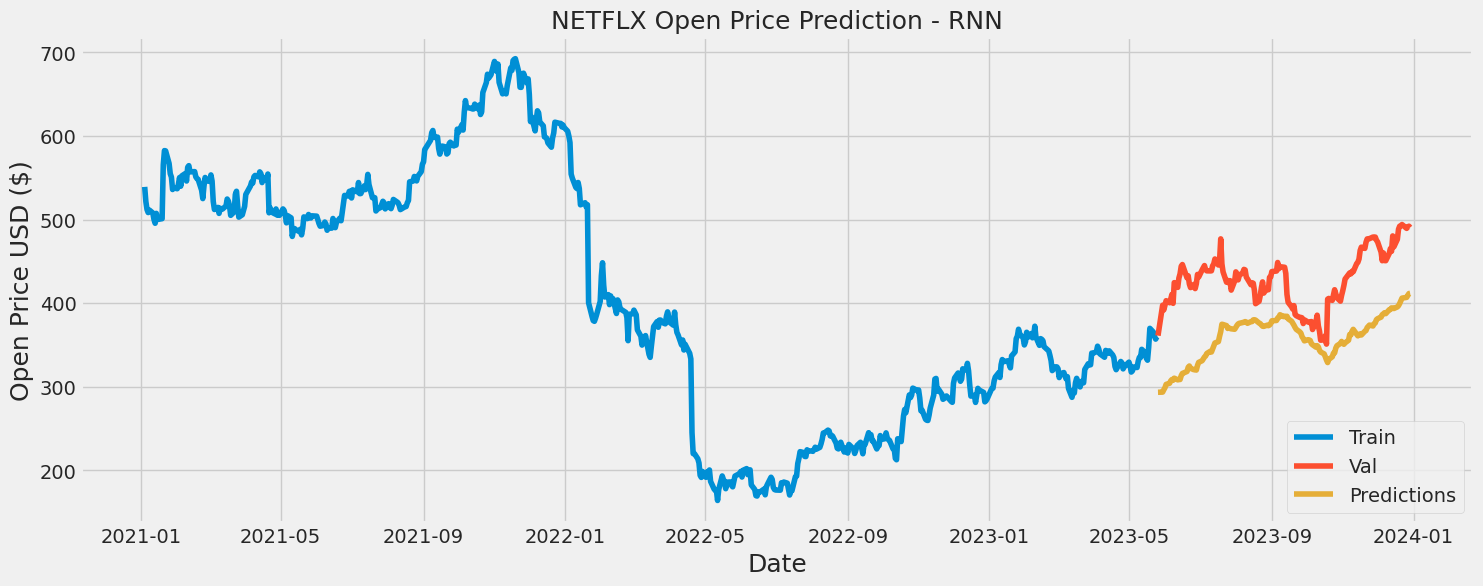

Processing predictions for NVIDIA...
Handling NaN for NVIDIA data.
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
NVIDIA RMSE: 3.6883191286308197
NVIDIA MAE: 2.7699343378428396
NVIDIA R² Score: 0.8905498114765761


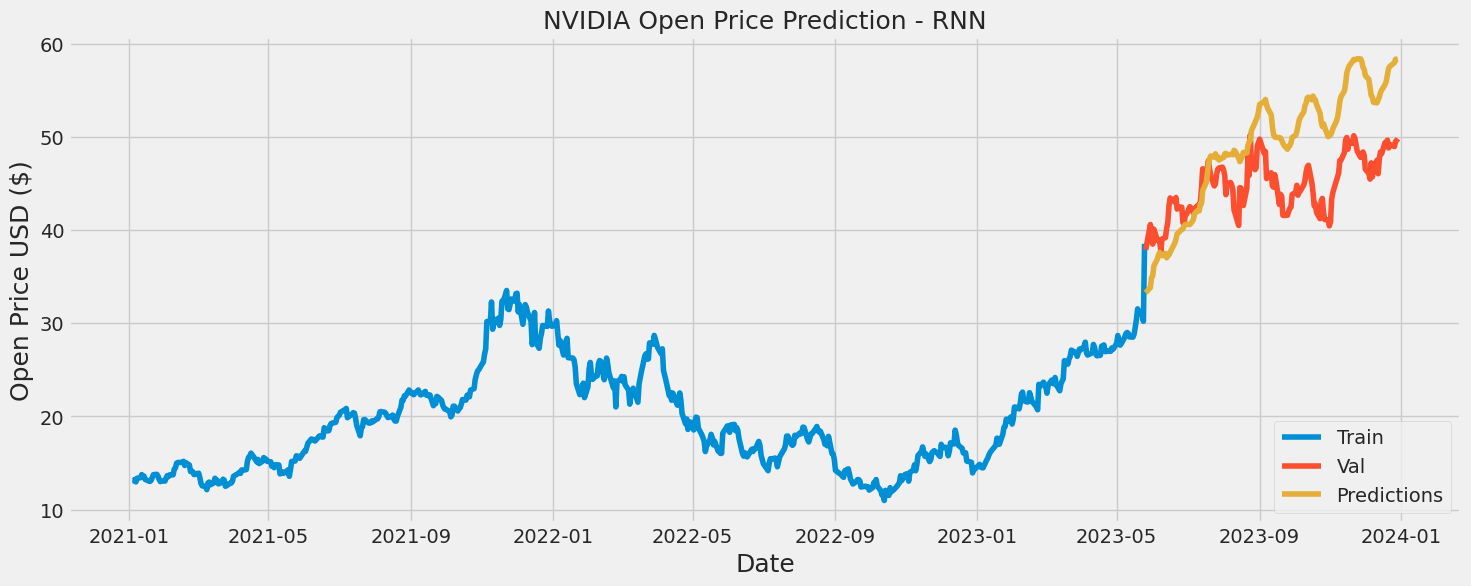

In [ ]:
# Tạo biểu đồ dự đoán cho từng công ty
for company, company_df in company_dataframes.items():
    print(f"Processing predictions for {company}...")

    # Chọn dữ liệu của công ty
    features = company_df.drop(['Open'], axis=1).values
    target = company_df['Open'].values

    # Xử lý NaN trước khi chuẩn hóa
    if np.isnan(features).any() or np.isnan(target).any():
        print(f"Handling NaN for {company} data.")
        col_means = np.nanmean(features, axis=0)
        nan_indices = np.where(np.isnan(features))
        for col in nan_indices[1]:
            features[:, col] = np.nan_to_num(features[:, col], nan=col_means[col])
        target = np.nan_to_num(target, nan=np.nanmean(target))

    # Chuẩn hóa dữ liệu
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)
    target_scaler = MinMaxScaler()
    scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))

    # Tạo dữ liệu huấn luyện
    training_data_len = int(np.ceil(len(features) * 0.8))
    train_features = scaled_features[:training_data_len, :]
    train_target = scaled_target[:training_data_len, :]

    x_train, y_train = [], []
    for i in range(60, len(train_features)):
        x_train.append(train_features[i-60:i, :])
        y_train.append(train_target[i, 0])


    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

    # Dự đoán trên dữ liệu kiểm tra
    x_test, y_test = [], []
    for i in range(60, len(scaled_features)):
        x_test.append(scaled_features[i-60:i])
        y_test.append(scaled_target[i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
    x_test_scaled = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

    x_train_flattened = x_train_scaled.reshape(x_train_scaled.shape[0], -1)
    x_test_flattened = x_test_scaled.reshape(x_test_scaled.shape[0], -1)


    # Thực hiện dự đoán
    predictions = ffnn_model.predict(x_test_flattened)
    predictions = target_scaler.inverse_transform(predictions)

    # Tính RMSE
    actual = target[60:]
    rmse = np.sqrt(np.mean(((predictions.flatten() - actual) ** 2)))
    print(f"{company} RMSE: {rmse}")

    # Tính MAE (Mean Absolute Error)
    mae = mean_absolute_error(actual, predictions.flatten())
    print(f"{company} MAE: {mae}")

    # Tính R² Score
    r2 = r2_score(actual, predictions.flatten())
    print(f"{company} R² Score: {r2}")

    # Biểu đồ
    train = company_df[:training_data_len]
    valid = company_df[training_data_len:]
    valid = valid.copy()
    valid['Predictions'] = predictions[-len(valid):]

    plt.figure(figsize=(16, 6))
    plt.title(f'{company} Open Price Prediction - RNN', fontsize=18)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Open Price USD ($)', fontsize=18)
    plt.plot(train['Open'], label='Train')
    plt.plot(valid['Open'], label='Val')
    plt.plot(valid['Predictions'], label='Predictions')
    plt.legend(loc='lower right')
    plt.show()


### Other models

#### Linear Regression

In [ ]:
# Khởi tạo mô hình Linear Regression
lr_model = LinearRegression()

# Huấn luyện mô hình với dữ liệu đã làm phẳng
lr_model.fit(x_train_flattened, y_train)

LinearRegression()

In [ ]:
# Dự đoán trên dữ liệu kiểm tra
y_pred = lr_model.predict(x_test_flattened)

# Chuyển kết quả dự đoán về thang đo ban đầu
y_pred_inverse = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inverse = target_scaler.inverse_transform(np.array(y_test).reshape(-1, 1))


In [ ]:
# Tính toán các chỉ số đánh giá
mae_lr = mean_absolute_error(y_test_inverse, y_pred_inverse)
rmse_lr = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
r2_lr = r2_score(y_test_inverse, y_pred_inverse)

print("Mean Absolute Error (MAE):", mae_lr)
print("Root Mean Squared Error (RMSE):", rmse_lr)
print("R² Score:", r2_lr)


Mean Absolute Error (MAE): 0.4134336086782216
Root Mean Squared Error (RMSE): 0.7997674148729128
R² Score: 0.9948537966495694


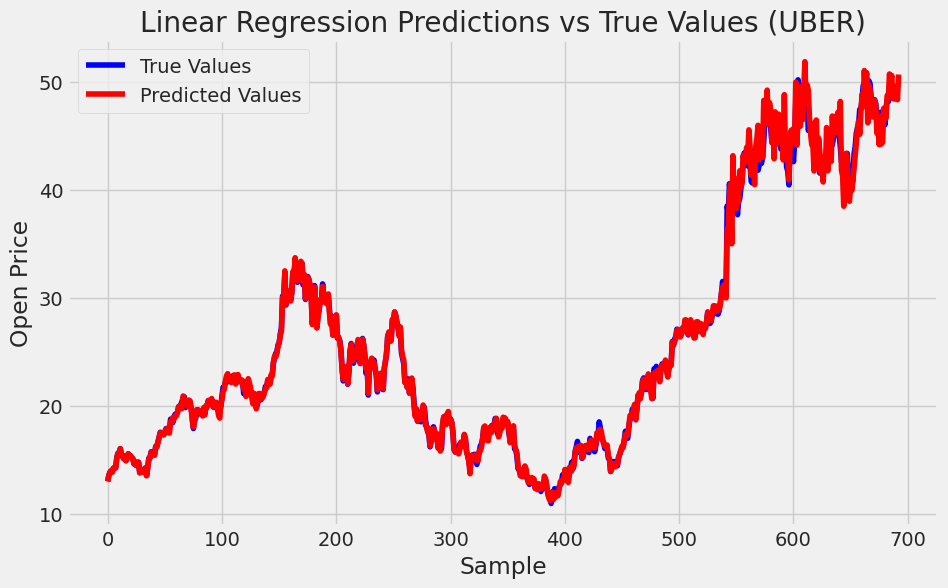

In [ ]:
# Trực quan hóa kết quả
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse, label="True Values", color='blue')
plt.plot(y_pred_inverse, label="Predicted Values", color='red')
plt.title(f"Linear Regression Predictions vs True Values ({company_name})")
plt.xlabel("Sample")
plt.ylabel("Open Price")
plt.legend()
plt.show()



In [ ]:
y_train_pred = lr_model.predict(x_train_flattened)
y_train_pred_inverse = target_scaler.inverse_transform(y_train_pred.reshape(-1, 1))
y_train_actual_inverse = target_scaler.inverse_transform(y_train.reshape(-1, 1))

mae_train = mean_absolute_error(y_train_actual_inverse, y_train_pred_inverse)
rmse_train = np.sqrt(mean_squared_error(y_train_actual_inverse, y_train_pred_inverse))
r2_train = r2_score(y_train_actual_inverse, y_train_pred_inverse)

print("Train - MAE:", mae_train)
print("Train - RMSE:", rmse_train)
print("Train - R²:", r2_train)


Train - MAE: 0.18146688269052524
Train - RMSE: 0.2515481344419261
Train - R²: 0.9978297243560884


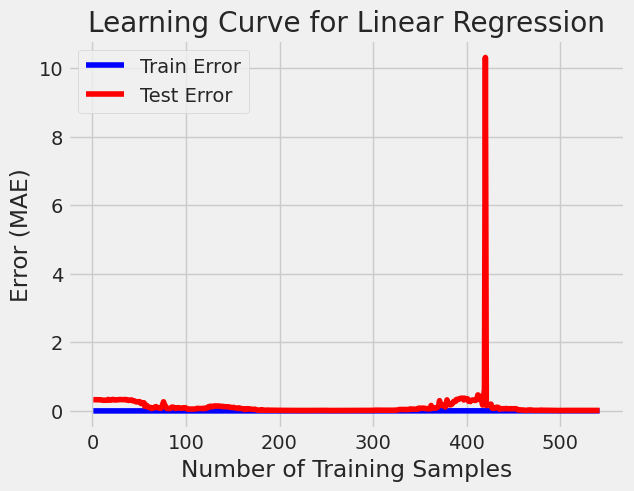

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Giả sử bạn đã chuẩn bị dữ liệu
# X_train, y_train, X_test, y_test là dữ liệu huấn luyện và kiểm tra

train_errors = []
test_errors = []

# Huấn luyện Linear Regression trên các tập con của dữ liệu huấn luyện
for m in range(1, len(x_train_flattened)):
    x_train_flattened_sub = x_train_flattened[:m]
    y_train_sub = y_train[:m]

    # Huấn luyện mô hình
    model = LinearRegression()
    model.fit(x_train_flattened_sub, y_train_sub)

    # Dự đoán và tính toán lỗi trên tập huấn luyện và kiểm tra
    train_pred = model.predict(x_train_flattened_sub)
    test_pred = model.predict(x_test_flattened)

    # Tính toán MAE hoặc RMSE
    train_error = mean_absolute_error(y_train_sub, train_pred)
    test_error = mean_absolute_error(y_test, test_pred)

    train_errors.append(train_error)
    test_errors.append(test_error)

# Vẽ Learning Curve
plt.plot(range(1, len(x_train_flattened)), train_errors, label="Train Error", color='blue')
plt.plot(range(1, len(x_train_flattened)), test_errors, label="Test Error", color='red')
plt.xlabel('Number of Training Samples')
plt.ylabel('Error (MAE)')
plt.title('Learning Curve for Linear Regression')
plt.legend()
plt.grid(True)
plt.show()


#### SVM

In [ ]:
# SVM Model
svm_model = SVR(kernel='rbf',gamma = 0.05,epsilon=0.1)  # Sử dụng kernel RBF
svm_model.fit(x_train_flattened, y_train)

# Dự đoán
y_pred_svm = svm_model.predict(x_test_flattened)

# Đánh giá mô hình
mse_svm = mean_squared_error(y_test, y_pred_svm)
mae_svm = mean_absolute_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)

print("SVM Results:")
print(f"Mean Squared Error: {mse_svm}")
print(f"Mean Absolute Error: {mae_svm}")
print(f"R2 Score: {r2_svm}")


SVM Results:
Mean Squared Error: 0.06722240873372048
Mean Absolute Error: 0.15337459384971688
R2 Score: 0.16700524587269094


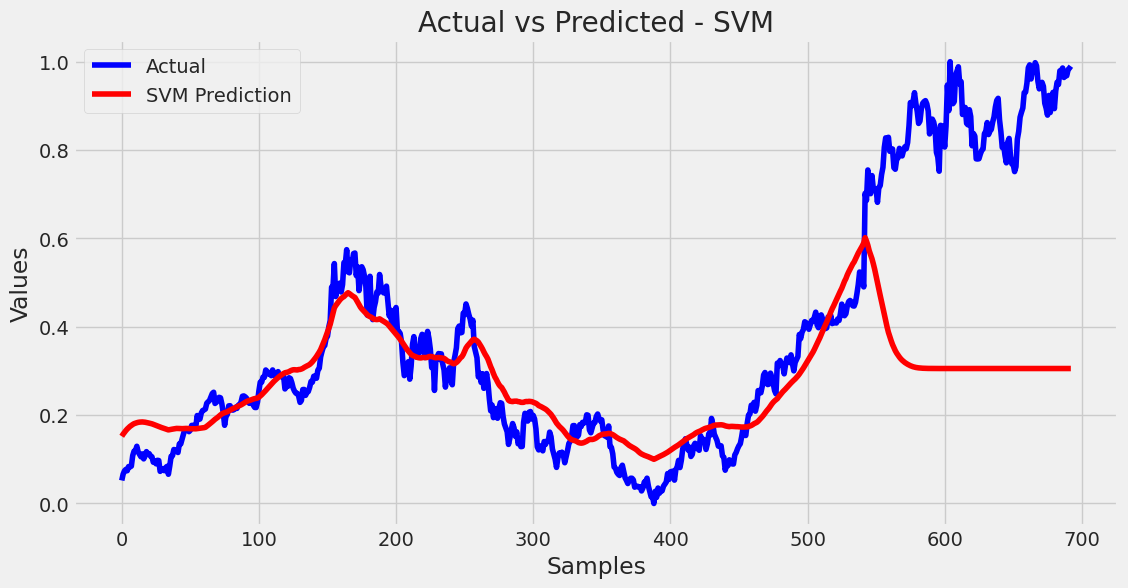

In [ ]:
# Biểu đồ SVM
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', color='blue')  # Giá trị thực tế
plt.plot(y_pred_svm, label='SVM Prediction', color='red')  # Dự đoán SVM
plt.title("Actual vs Predicted - SVM")
plt.xlabel("Samples")
plt.ylabel("Values")
plt.legend()
plt.show()


#### Decision Tree

In [ ]:
# Decision Tree Model
dt_model = DecisionTreeRegressor(max_depth=10, random_state=42)
dt_model.fit(x_train_flattened, y_train)

# Dự đoán
y_pred_dt = dt_model.predict(x_test_flattened)

# Đánh giá mô hình
mse_dt = mean_squared_error(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("Decision Tree Results:")
print(f"Mean Squared Error: {mse_dt}")
print(f"Mean Absolute Error: {mae_dt}")
print(f"R2 Score: {r2_dt}")


Decision Tree Results:
Mean Squared Error: 0.0068797403338564395
Mean Absolute Error: 0.03499075849287833
R2 Score: 0.9147488506316233


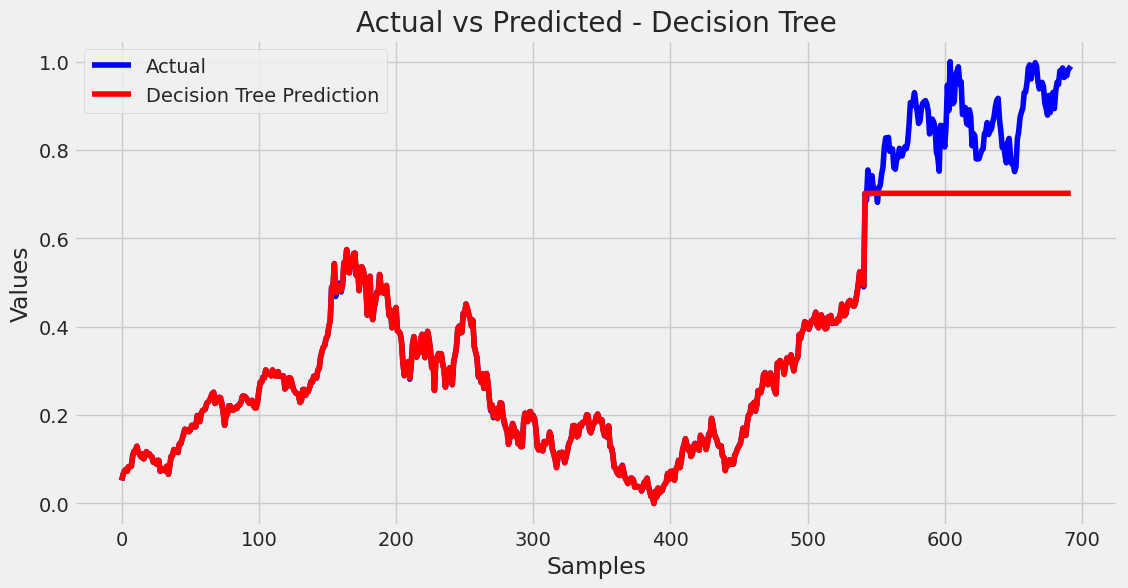

In [ ]:
# Biểu đồ Decision Tree
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', color='blue')  # Giá trị thực tế
plt.plot(y_pred_dt, label='Decision Tree Prediction', color='red')  # Dự đoán Decision Tree
plt.title("Actual vs Predicted - Decision Tree")
plt.xlabel("Samples")
plt.ylabel("Values")
plt.legend()
plt.show()



#### Random Forest

In [ ]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(x_train_flattened, y_train)

# Dự đoán
y_pred_rf = rf_model.predict(x_test_flattened)

# Đánh giá mô hình
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Results:")
print(f"Mean Squared Error: {mse_rf}")
print(f"Mean Absolute Error: {mae_rf}")
print(f"R2 Score: {r2_rf}")


Random Forest Results:
Mean Squared Error: 0.013284148289439758
Mean Absolute Error: 0.05343270454411685
R2 Score: 0.835387840950695


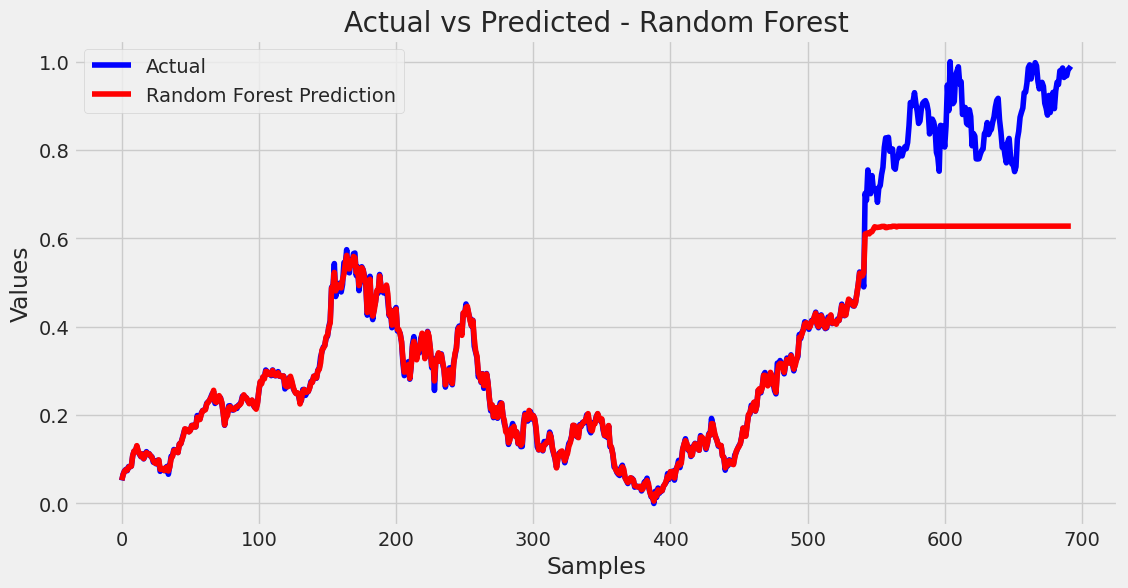

In [ ]:
# Biểu đồ Random Forest
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', color='blue')  # Giá trị thực tế
plt.plot(y_pred_rf, label='Random Forest Prediction', color='red')  # Dự đoán Random Forest
plt.title("Actual vs Predicted - Random Forest")
plt.xlabel("Samples")
plt.ylabel("Values")
plt.legend()
plt.show()


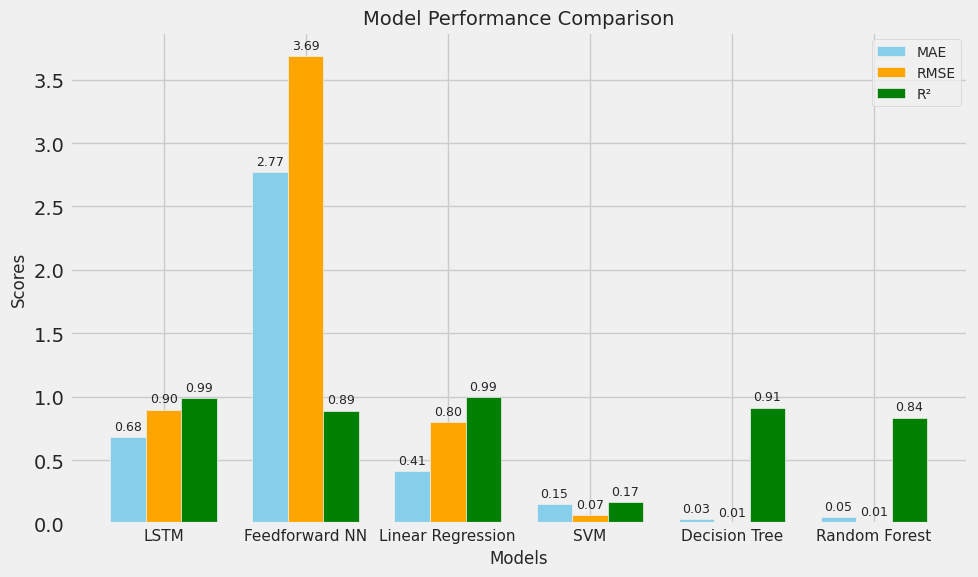

In [ ]:
# Hiệu năng của các mô hình (giá trị giả định, thay bằng giá trị thực tế của bạn)
models = ['LSTM', 'Feedforward NN', 'Linear Regression', 'SVM', 'Decision Tree','Random Forest']
mae_scores = [mae_ltsm, mae_ffnn, mae_lr, mae_svm, mae_dt,mae_rf]  # MAE của từng mô hình
rmse_scores = [rmse_ltsm, rmse_ffnn, rmse_lr, mse_svm, mse_dt,mse_rf]  # RMSE của từng mô hình
r2_scores = [r2_ltsm, r2_ffnn, r2_lr, r2_svm, r2_dt,r2_rf]    # R^2 của từng mô hình

# Thiết lập vị trí cho các cột
x = np.arange(len(models))
width = 0.25  # Độ rộng của các cột

# Tạo biểu đồ
fig, ax = plt.subplots(figsize=(10, 6))

# Vẽ từng loại cột
bar1 = ax.bar(x - width, mae_scores, width, label='MAE', color='skyblue')
bar2 = ax.bar(x, rmse_scores, width, label='RMSE', color='orange')
bar3 = ax.bar(x + width, r2_scores, width, label='R²', color='green')

# Thêm nhãn, tiêu đề và chú thích
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=11)
ax.legend(fontsize=10)

# Hiển thị giá trị trên các cột
def add_values(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

add_values(bar1)
add_values(bar2)
add_values(bar3)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()
